In [22]:
#MiniProjectB:  Introducing New Gen of Fighting, Normal, and Ground Pokemon with High Special Atk.
#by Mai Kobayashi, Armando Quinones, and Quoc Tran

#The relationship between Pokemon type and Special Attack potential is critical for Nintendo’s profitability because offensive Pokemon drive player excitement, engagement, 
#and card/game sales. 

#We ran a LASSO regression model with Special Attack as output on core stats and types, which isolates the effect of each type while holding other attributes constant. 
#Results show Fighting, Normal, and Ground types have significantly lower (negative) Special Attack coefficients.
#We recommend creating new rare Fighting, Normal, and Ground type Pokemon with higher Special Attacks to introduce surprising offensive Pokemon and increase player interest.

#See model on line 17 and key figures on lines 20 and 21 below.

In [1]:
library(tidyverse) 
pokemon_df <- read_csv("../data/pokemon.csv") 
library(tidyverse) 
install.packages("fastDummies") 
library(fastDummies)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 1215 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Name, Type 1, Type 2
dbl (8): Index, Total, HP, Attack, Defense, SP. Atk., SP. Def, Speed

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
head(pokemon_df, 5)

Index,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,NA,309,39,52,43,60,50,65


In [3]:
install.packages("fastDummies")
library(tidyverse)
library(fastDummies)

pokemon_df <- read_csv("../data/pokemon.csv") %>%
  # ensure names are consistent
  rename(
    Type_1 = `Type 1`,
    Type_2 = `Type 2`
  ) %>%
  # replace NA in Type_2
  mutate(Type_2 = replace_na(Type_2, "None")) %>%
  # make sure they are factors before dummying
  mutate(across(c(Type_1, Type_2), as.factor)) %>%
  # create dummy columns
  dummy_cols(select_columns = c("Type_1", "Type_2"),
             remove_selected_columns = FALSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Rows: 1215 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Name, Type 1, Type 2
dbl (8): Index, Total, HP, Attack, Defense, SP. Atk., SP. Def, Speed

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
pokemon_num <- pokemon_df %>%
  select(-Index) %>%           # remove Index column
  select(where(is.numeric))    # keep only numeric columns

glimpse(pokemon_num)

Rows: 1,215
Columns: 44
$ Total           <dbl> 318, 405, 525, 625, 309, 405, 534, 634, 634, 314, 405,…
$ HP              <dbl> 45, 60, 80, 80, 39, 58, 78, 78, 78, 44, 59, 79, 79, 45…
$ Attack          <dbl> 49, 62, 82, 100, 52, 64, 84, 130, 104, 48, 63, 83, 103…
$ Defense         <dbl> 49, 63, 83, 123, 43, 58, 78, 111, 78, 65, 80, 100, 120…
$ `SP. Atk.`      <dbl> 65, 80, 100, 122, 60, 80, 109, 130, 159, 50, 65, 85, 1…
$ `SP. Def`       <dbl> 65, 80, 100, 120, 50, 65, 85, 85, 115, 64, 80, 105, 11…
$ Speed           <dbl> 45, 60, 80, 80, 65, 80, 100, 100, 100, 43, 58, 78, 78,…
$ Type_1_Bug      <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, …
$ Type_1_Dark     <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Type_1_Dragon   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Type_1_Electric <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Type_1_Fairy    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Type_1_Fightin

In [17]:
library(glmnet)
library(dplyr)

# RESPONSE = Sp. Atk
y <- pokemon_num$`SP. Atk.`

# PREDICTORS = all other numeric columns except SP. Atk.
X <- pokemon_num %>%
  select(-`SP. Atk.`) %>%
  as.matrix()

# Run cross-validated lasso
set.seed(123)
cv_fit_spatk <- cv.glmnet(X, y, alpha = 1)

# Get coefficients at lambda.min
coefs_mat <- as.matrix(coef(cv_fit_spatk, s = "lambda.min"))

# Create table with variable names and nonzero values
coef_df <- tibble(
  variable = rownames(coefs_mat),
  value = coefs_mat[, 1]
) %>%
  filter(value != 0)

# Count variables
total_vars <- nrow(coefs_mat) - 1        # minus intercept
selected_vars <- nrow(coef_df) - 1       # minus intercept in nonzero list
eliminated_vars <- total_vars - selected_vars

# Count variables
total_vars <- nrow(coefs_mat) - 1        # minus intercept
selected_vars <- nrow(coef_df) - 1       # minus intercept in nonzero list
eliminated_vars <- total_vars - selected_vars

lambda_min <- cv_fit_spatk$lambda.min

cat("\nLASSO Summary at lambda.min\n")
cat("--------------------------------\n")
cat("Lambda (lambda.min):", round(lambda_min, 5), "\n")
cat("Total predictors:", total_vars, "\n")
cat("Selected predictors:", selected_vars, "\n")
cat("Eliminated predictors:", eliminated_vars, "\n\n")

coef_df_sorted <- coef_df %>%
  filter(variable != "(Intercept)") %>%
  arrange(value)   # most negative first

print(coef_df_sorted)





LASSO Summary at lambda.min
--------------------------------
Lambda (lambda.min): 0.08065 
Total predictors: 43 
Selected predictors: 15 
Eliminated predictors: 28 

# A tibble: 15 × 2
   variable          value
   <chr>             <dbl>
 1 Defense         -0.962 
 2 Attack          -0.955 
 3 HP              -0.952 
 4 Speed           -0.947 
 5 SP. Def         -0.941 
 6 Type_1_Fighting -0.518 
 7 Type_1_Normal   -0.262 
 8 Type_1_Ground   -0.127 
 9 Type_1_Bug      -0.0142
10 Type_1_Ghost     0.0180
11 Type_1_Fire      0.151 
12 Type_1_Electric  0.166 
13 Type_2_Dragon    0.242 
14 Type_1_Psychic   0.296 
15 Total            0.960 


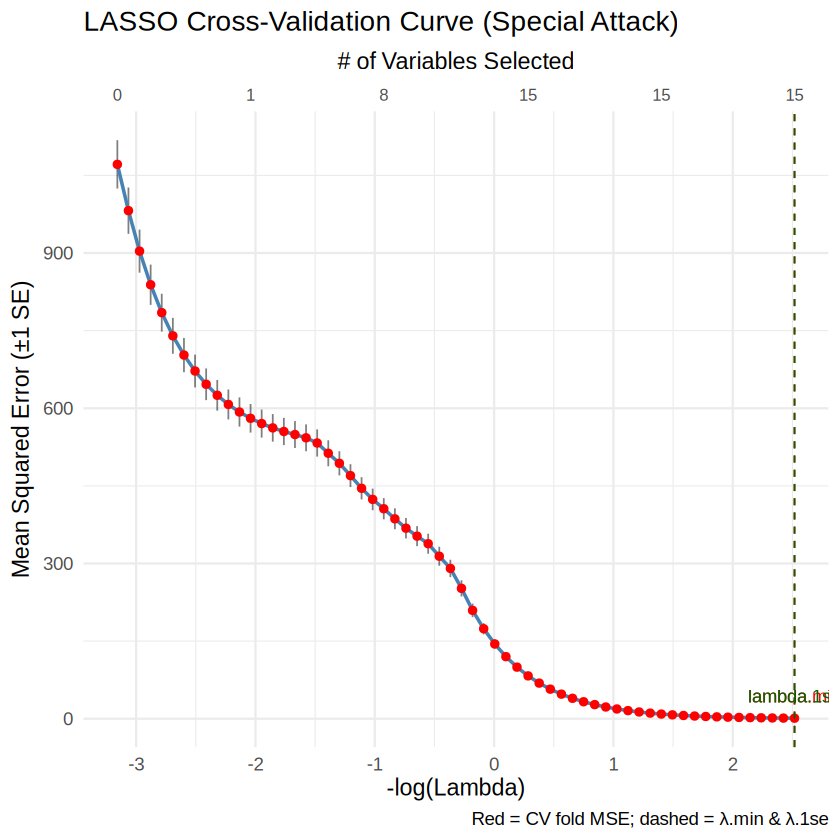

In [20]:
df_simple <- data.frame(
  lambda = cv_fit_spatk$lambda,
  neglog_lambda = -log(cv_fit_spatk$lambda),   # changed
  mse = cv_fit_spatk$cvm,
  se = cv_fit_spatk$cvsd,
  nzero = cv_fit_spatk$nzero
)

# choose ~6 evenly-spaced ticks along neglog(lambda) axis
tick_idx <- round(seq(1, nrow(df_simple), length.out = 6))

ggplot(df_simple, aes(x = neglog_lambda, y = mse)) +   # changed
  geom_errorbar(aes(ymin = mse - se, ymax = mse + se), width = 0, alpha = 0.5) +
  geom_line(color = "steelblue", linewidth = 1) +
  geom_point(color = "red", size = 2) +

  geom_vline(xintercept = -log(cv_fit_spatk$lambda.min),   # changed
             linetype = "dashed", color = "red") +
  geom_vline(xintercept = -log(cv_fit_spatk$lambda.1se),   # changed
             linetype = "dashed", color = "darkgreen") +

  annotate("text",
           x = -log(cv_fit_spatk$lambda.min),              # changed
           y = min(df_simple$mse),
           label = "lambda.min",
           color = "red", vjust = -1.2) +
  annotate("text",
           x = -log(cv_fit_spatk$lambda.1se),              # changed
           y = min(df_simple$mse),
           label = "lambda.1se",
           color = "darkgreen", vjust = -1.2) +

  scale_x_continuous(
    name = "-log(Lambda)",                                # changed
    sec.axis = sec_axis(
      ~.,
      breaks = df_simple$neglog_lambda[tick_idx],         # changed
      labels = df_simple$nzero[tick_idx],
      name = "# of Variables Selected"
    )
  ) +

  labs(
    title = "LASSO Cross-Validation Curve (Special Attack)",
    y = "Mean Squared Error (±1 SE)",
    caption = "Red = CV fold MSE; dashed = λ.min & λ.1se"
  ) +

  theme_minimal(base_size = 14) +
  theme(
    axis.title.x.top = element_text(margin = margin(b = 10)),
    axis.text.x.top  = element_text(size = 10)
  )




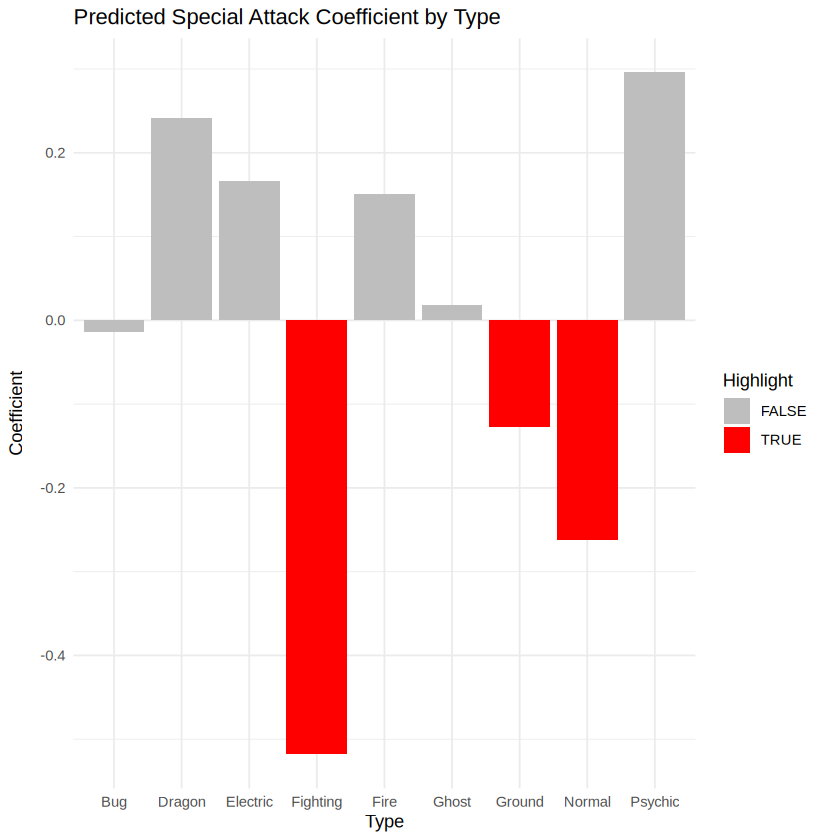

In [21]:
library(ggplot2)
type_coef_df <- data.frame(
  Type = c("Bug", "Electric", "Fighting", "Fire", "Ghost", "Ground", "Normal", "Psychic", "Dragon"),
  Coefficient = c(-0.0142, 0.166, -0.518, 0.151, 0.0180, -0.127, -0.262, 0.296, 0.242)
)
type_coef_df$Highlight <- type_coef_df$Type %in% c("Fighting", "Normal", "Ground")

ggplot(type_coef_df, aes(x = Type, y = Coefficient, fill = Highlight)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = c("gray", "red")) +
  labs(title = "Predicted Special Attack Coefficient by Type",
       x = "Type", y = "Coefficient") +
  theme_minimal()
